In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import math
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix

In [354]:
df.columns

Index(['Unnamed: 0_phase1', 'Cohort_phase1', 'Round', 'Phase_phase1',
       'Individual', 'Puzzler_phase1', 'HR_TD_Mean_phase1',
       'HR_TD_Median_phase1', 'HR_TD_std_phase1', 'HR_TD_Min_phase1',
       ...
       'nervous_diff_phase1_phase2', 'nervous_diff_phase2_phase3',
       'attentive_diff_phase1_phase2', 'attentive_diff_phase2_phase3',
       'afraid_diff_phase1_phase2', 'afraid_diff_phase2_phase3',
       'active_diff_phase1_phase2', 'active_diff_phase2_phase3',
       'determined_diff_phase1_phase2', 'determined_diff_phase2_phase3'],
      dtype='object', length=222)

# **Phase 1 vs. Phase 2**

In [355]:
# Load data
df = pd.read_csv('../data/HR_data_wide_emotions.csv')

# df = df[df['Puzzler_phase1']==0]
diff_emotions_columns = ["Frustrated_diff_phase1_phase2","upset_diff_phase1_phase2","hostile_diff_phase1_phase2",
                         "alert_diff_phase1_phase2","ashamed_diff_phase1_phase2","inspired_diff_phase1_phase2",
                         "nervous_diff_phase1_phase2","attentive_diff_phase1_phase2","afraid_diff_phase1_phase2",
                         "active_diff_phase1_phase2","determined_diff_phase1_phase2"]

df_diff_emotions = df[diff_emotions_columns]

In [356]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_diff_emotions)
scaled_df_encoded = pd.DataFrame(scaler.transform(df_diff_emotions),columns= df_diff_emotions.columns )

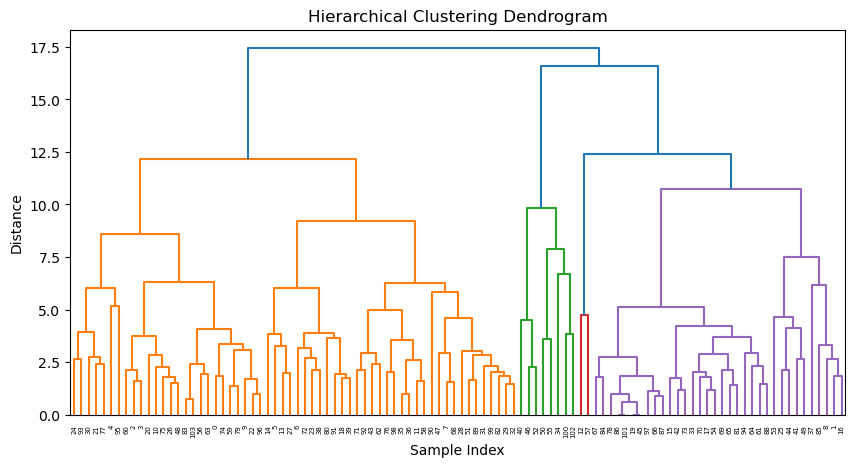

In [357]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(scaled_df_encoded, method='ward', metric='euclidean')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

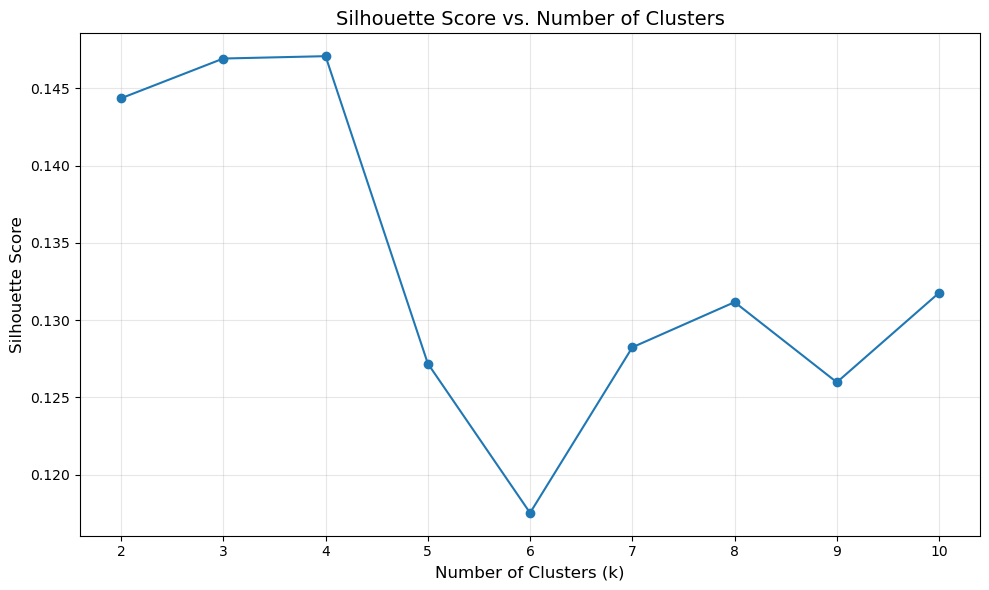

In [358]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Calculate Silhouette Scores for k from 2 to 10
silhouette_scores = {} # Store scores for plotting

# Define the range for k
k_range = range(2, 11) # k from 2 to 10 inclusive

for k in k_range:
    # Get cluster labels for the current k
    cluster_labels = fcluster(Z, k, criterion='maxclust')

    # Check if the number of unique labels formed is valid for silhouette score
    n_labels = len(np.unique(cluster_labels))
    if n_labels > 1:
        score = silhouette_score(scaled_df_encoded, cluster_labels, metric='euclidean')
        silhouette_scores[k] = score # Store the score

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'o-', color='#1f77b4')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)

plt.xticks(list(silhouette_scores.keys()))
plt.tight_layout()
plt.show()

Optimal number of clusters based on Gap Statistic: 3


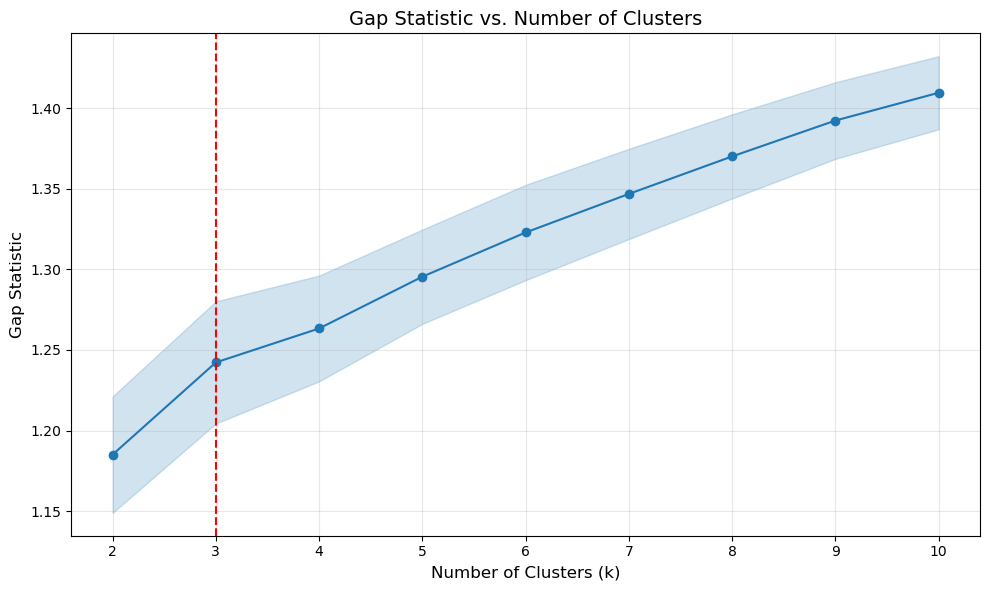

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

# Define function to compute within-cluster sum of squares
def compute_wss(data, labels):
    """Compute within-cluster sum of squares"""
    n_clusters = len(np.unique(labels))
    wss = 0
    for i in range(1, n_clusters + 1):  # Cluster labels typically start from 1 in hierarchical clustering
        cluster_points = data[labels == i]
        if len(cluster_points) > 0:  # Ensure cluster is not empty
            centroid = np.mean(cluster_points, axis=0)
            wss += np.sum(np.sum((cluster_points - centroid) ** 2, axis=1))
    return wss

# Gap Statistic Implementation
def gap_statistic(data, k_range, n_refs=10, random_state=42):
    
    # Set random seed
    np.random.seed(random_state)
    
    # Convert data to numpy array if it's not already
    data = np.array(data)
    
    # Get the range of the data
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Initialize arrays to store results
    gap_values = np.zeros(len(k_range))
    log_w_k = np.zeros(len(k_range))
    log_w_k_refs = np.zeros((len(k_range), n_refs))
    s_k = np.zeros(len(k_range))
    
    # Compute the log of the within-cluster dispersion for the actual data
    for i, k in enumerate(k_range):
        # Get cluster labels from hierarchical clustering
        cluster_labels = fcluster(Z, k, criterion='maxclust')
        
        # Compute within-cluster sum of squares
        wss = compute_wss(data, cluster_labels)
        log_w_k[i] = np.log(wss) if wss > 0 else 0
    
    # Generate reference datasets and compute their log(W_k)
    for j in range(n_refs):
        # Generate uniform random data within the range of the original data
        ref_data = np.random.uniform(min_vals, max_vals, data.shape)
        
        for i, k in enumerate(k_range):
            # Perform hierarchical clustering on reference data
            model = AgglomerativeClustering(n_clusters=k, linkage='ward')
            ref_labels = model.fit_predict(ref_data) + 1  # Add 1 to match fcluster label convention
            
            # Compute within-cluster sum of squares
            wss_ref = compute_wss(ref_data, ref_labels)
            log_w_k_refs[i, j] = np.log(wss_ref) if wss_ref > 0 else 0
    
    # Compute the gap statistic and standard error
    for i in range(len(k_range)):
        gap_values[i] = np.mean(log_w_k_refs[i]) - log_w_k[i]
        sdk = np.std(log_w_k_refs[i]) * np.sqrt(1 + 1/n_refs)
        s_k[i] = sdk
    
    return gap_values, s_k

# Define the range for k
k_range = list(range(2, 11))  # k from 2 to 10 inclusive

# Compute the gap statistic
gap_values, s_k = gap_statistic(scaled_df_encoded, k_range)

# Find the optimal k using the gap statistic criterion
# The optimal k is the smallest k such that gap(k) >= gap(k+1) - s'_k+1
optimal_k = None
for i in range(len(k_range) - 1):
    if gap_values[i] >= gap_values[i+1] - s_k[i+1]:
        optimal_k = k_range[i]
        break

if optimal_k is None:
    optimal_k = k_range[-1]

print(f"Optimal number of clusters based on Gap Statistic: {optimal_k}")

# Plot the gap statistic
plt.figure(figsize=(10, 6))
plt.plot(k_range, gap_values, 'o-', color='#1f77b4')
plt.fill_between(k_range, gap_values - s_k, gap_values + s_k, alpha=0.2, color='#1f77b4')
plt.axvline(x=optimal_k, color='red', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Gap Statistic', fontsize=12)
plt.title('Gap Statistic vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

From Shiloutte and Gap Criterion --> k_opt = 3

In [360]:
# We see that the optimal number of clusters is 4
k_opt = 3
cluster_labels = fcluster(Z, k_opt, criterion='maxclust')
cluster_labels

array([1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 1, 1, 2, 3, 3, 1,
       3, 3, 2, 1, 1, 3, 2, 1, 2, 3, 3, 2, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3,
       3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2, 3, 2, 1], dtype=int32)

Unique cluster labels: [1, 2, 3]
Cluster 1: 60 samples
Cluster 2: 8 samples
Cluster 3: 36 samples


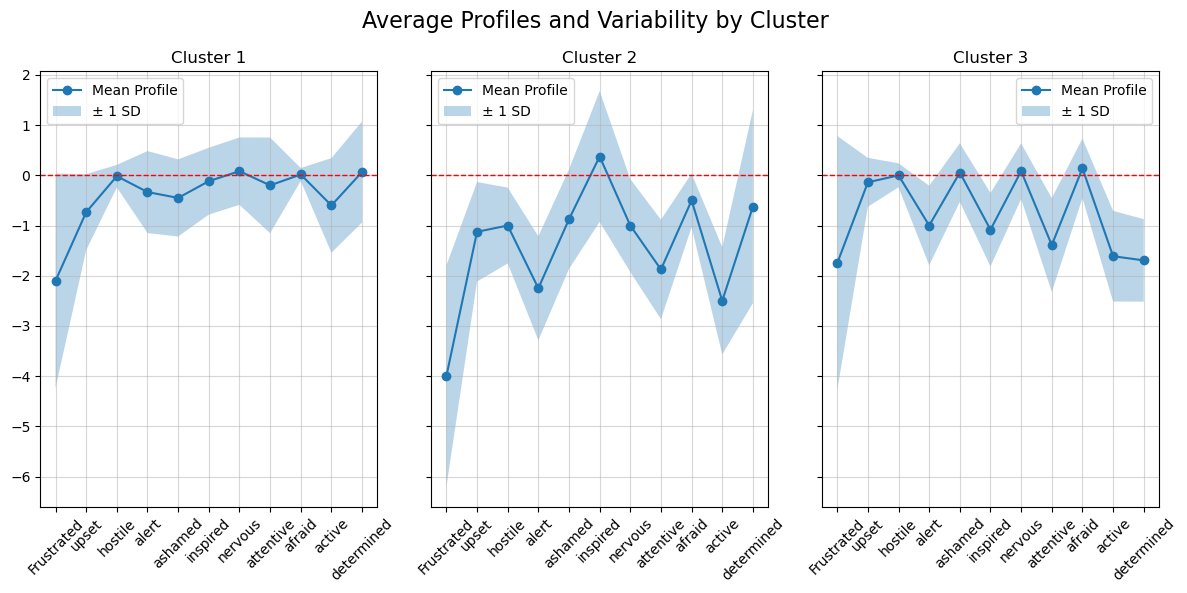

In [361]:
emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

# 3. Create a DataFrame to hold the cluster assignments
df_emotions_clustered = df_diff_emotions.copy()
df_emotions_clustered['Cluster'] = cluster_labels

# Check what cluster labels actually exist
unique_clusters = sorted(df_emotions_clustered['Cluster'].unique())
print(f"Unique cluster labels: {unique_clusters}")

# 4. Prepare for plotting
n_clusters = len(unique_clusters)
fig, axs = plt.subplots(1, n_clusters, figsize=(12, 6), sharey=True)

for i, cluster_id in enumerate(unique_clusters):
    cluster_data = df_emotions_clustered[df_emotions_clustered['Cluster'] == cluster_id]
    
    # Print the size of each cluster
    print(f"Cluster {cluster_id}: {len(cluster_data)} samples")
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(emotions_columns))
    
    # Plot
    axs[i].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[i].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    # Add horizontal line at y=0
    axs[i].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=1)
    
    axs[i].set_title(f'Cluster {cluster_id}')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(emotions_columns, rotation=45)
    axs[i].grid(True, alpha=.5)
    axs[i].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

In [362]:
# First, create a new dataframe with individual and cluster information
individual_clusters = pd.DataFrame({
    'Individual': df['Individual'],
    'Cluster': cluster_labels
})

# Create a cross-tabulation (contingency table)
cluster_distribution = pd.crosstab(
    individual_clusters['Individual'], 
    individual_clusters['Cluster'],
    rownames=['Individual'],
    colnames=['Cluster']
)

# Fill any missing values with 0 (in case some individuals don't appear in some clusters)
cluster_distribution = cluster_distribution.fillna(0).astype(int)

# Add a total column
cluster_distribution['Total'] = cluster_distribution.sum(axis=1)

# Determine the dominant cluster for each individual
dominant_cluster = cluster_distribution.iloc[:, :-1].idxmax(axis=1)
cluster_distribution['Dominant_Cluster'] = dominant_cluster

# Get the list of individuals in each dominant cluster
cluster_groups = {}
for cluster in sorted(dominant_cluster.unique()):
    individuals = dominant_cluster[dominant_cluster == cluster].index.tolist()
    cluster_groups[cluster] = individuals

# Print the individuals in each cluster
for cluster, individuals in cluster_groups.items():
    print(f"Individuals in Cluster {cluster}: {', '.join(map(str, individuals))}")

Individuals in Cluster 1: 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 26
Individuals in Cluster 2: 17
Individuals in Cluster 3: 2, 8, 20, 22


## **Phase 2 vs. Phase 3**

In [363]:
diff_emotions_columns = ["Frustrated_diff_phase2_phase3","upset_diff_phase2_phase3","hostile_diff_phase2_phase3",
                         "alert_diff_phase2_phase3","ashamed_diff_phase2_phase3","inspired_diff_phase2_phase3",
                         "nervous_diff_phase2_phase3","attentive_diff_phase2_phase3","afraid_diff_phase2_phase3",
                         "active_diff_phase2_phase3","determined_diff_phase2_phase3"]

df_diff_emotions = df[diff_emotions_columns]

In [364]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_diff_emotions)
scaled_df_encoded = pd.DataFrame(scaler.transform(df_diff_emotions),columns= df_diff_emotions.columns )

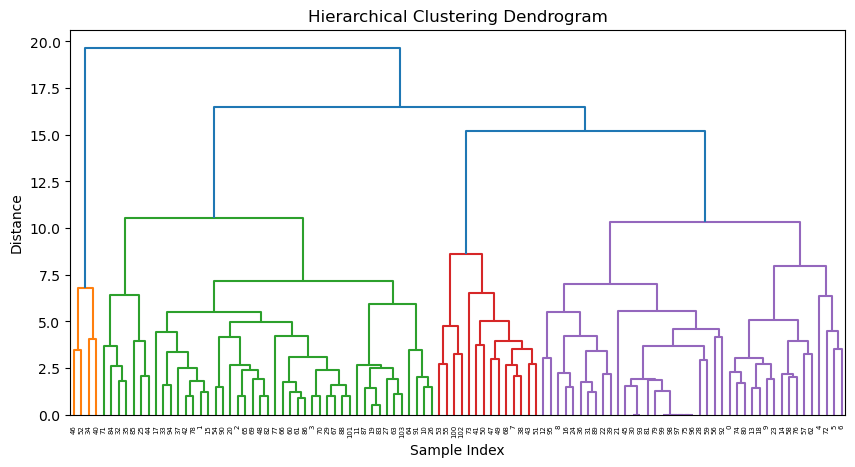

In [365]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(scaled_df_encoded, method='ward', metric='euclidean')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

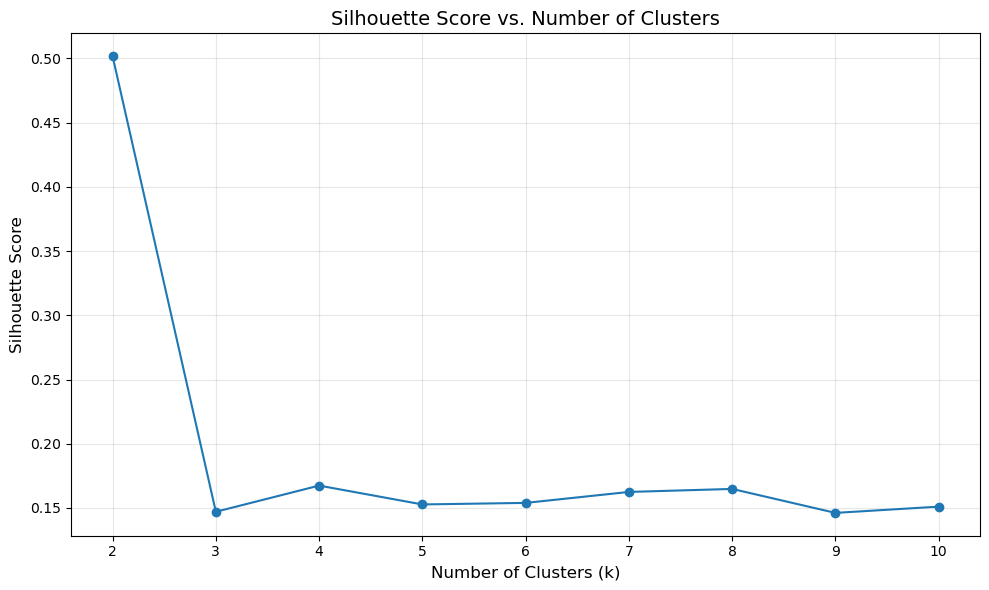

In [366]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Calculate Silhouette Scores for k from 2 to 10
silhouette_scores = {} # Store scores for plotting

# Define the range for k
k_range = range(2, 11) # k from 2 to 10 inclusive

for k in k_range:
    # Get cluster labels for the current k
    cluster_labels = fcluster(Z, k, criterion='maxclust')

    # Check if the number of unique labels formed is valid for silhouette score
    n_labels = len(np.unique(cluster_labels))
    if n_labels > 1:
        score = silhouette_score(scaled_df_encoded, cluster_labels, metric='euclidean')
        silhouette_scores[k] = score # Store the score

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'o-', color='#1f77b4')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)

plt.xticks(list(silhouette_scores.keys()))
plt.tight_layout()
plt.show()

Optimal number of clusters based on Gap Statistic: 4


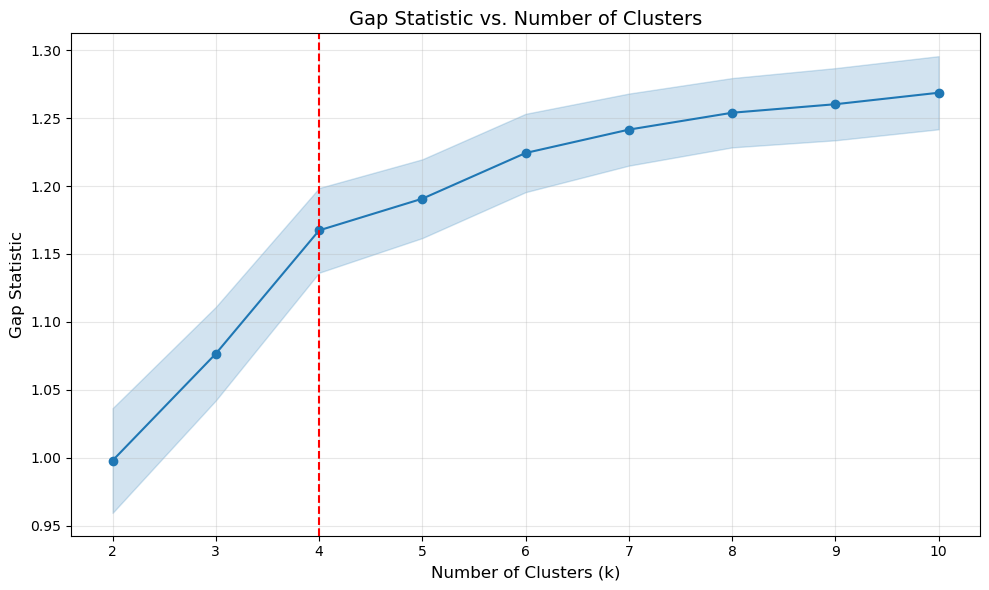

In [367]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

# Define function to compute within-cluster sum of squares
def compute_wss(data, labels):
    """Compute within-cluster sum of squares"""
    n_clusters = len(np.unique(labels))
    wss = 0
    for i in range(1, n_clusters + 1):  # Cluster labels typically start from 1 in hierarchical clustering
        cluster_points = data[labels == i]
        if len(cluster_points) > 0:  # Ensure cluster is not empty
            centroid = np.mean(cluster_points, axis=0)
            wss += np.sum(np.sum((cluster_points - centroid) ** 2, axis=1))
    return wss

# Gap Statistic Implementation
def gap_statistic(data, k_range, n_refs=10, random_state=42):
    
    # Set random seed
    np.random.seed(random_state)
    
    # Convert data to numpy array if it's not already
    data = np.array(data)
    
    # Get the range of the data
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Initialize arrays to store results
    gap_values = np.zeros(len(k_range))
    log_w_k = np.zeros(len(k_range))
    log_w_k_refs = np.zeros((len(k_range), n_refs))
    s_k = np.zeros(len(k_range))
    
    # Compute the log of the within-cluster dispersion for the actual data
    for i, k in enumerate(k_range):
        # Get cluster labels from hierarchical clustering
        cluster_labels = fcluster(Z, k, criterion='maxclust')
        
        # Compute within-cluster sum of squares
        wss = compute_wss(data, cluster_labels)
        log_w_k[i] = np.log(wss) if wss > 0 else 0
    
    # Generate reference datasets and compute their log(W_k)
    for j in range(n_refs):
        # Generate uniform random data within the range of the original data
        ref_data = np.random.uniform(min_vals, max_vals, data.shape)
        
        for i, k in enumerate(k_range):
            # Perform hierarchical clustering on reference data
            model = AgglomerativeClustering(n_clusters=k, linkage='ward')
            ref_labels = model.fit_predict(ref_data) + 1  # Add 1 to match fcluster label convention
            
            # Compute within-cluster sum of squares
            wss_ref = compute_wss(ref_data, ref_labels)
            log_w_k_refs[i, j] = np.log(wss_ref) if wss_ref > 0 else 0
    
    # Compute the gap statistic and standard error
    for i in range(len(k_range)):
        gap_values[i] = np.mean(log_w_k_refs[i]) - log_w_k[i]
        sdk = np.std(log_w_k_refs[i]) * np.sqrt(1 + 1/n_refs)
        s_k[i] = sdk
    
    return gap_values, s_k

# Define the range for k
k_range = list(range(2, 11))  # k from 2 to 10 inclusive

# Compute the gap statistic
gap_values, s_k = gap_statistic(scaled_df_encoded, k_range)

# Find the optimal k using the gap statistic criterion
# The optimal k is the smallest k such that gap(k) >= gap(k+1) - s'_k+1
optimal_k = None
for i in range(len(k_range) - 1):
    if gap_values[i] >= gap_values[i+1] - s_k[i+1]:
        optimal_k = k_range[i]
        break

if optimal_k is None:
    optimal_k = k_range[-1]

print(f"Optimal number of clusters based on Gap Statistic: {optimal_k}")

# Plot the gap statistic
plt.figure(figsize=(10, 6))
plt.plot(k_range, gap_values, 'o-', color='#1f77b4')
plt.fill_between(k_range, gap_values - s_k, gap_values + s_k, alpha=0.2, color='#1f77b4')
plt.axvline(x=optimal_k, color='red', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Gap Statistic', fontsize=12)
plt.title('Gap Statistic vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

In [368]:
# We see that the optimal number of clusters is 4
k_opt = 3
cluster_labels = fcluster(Z, k_opt, criterion='maxclust')
cluster_labels

array([3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 1, 2, 3, 2, 3, 3, 1, 3, 2, 3,
       2, 3, 1, 3, 2, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2], dtype=int32)

Unique cluster labels: [1, 2, 3]
Cluster 1: 4 samples
Cluster 2: 45 samples
Cluster 3: 55 samples


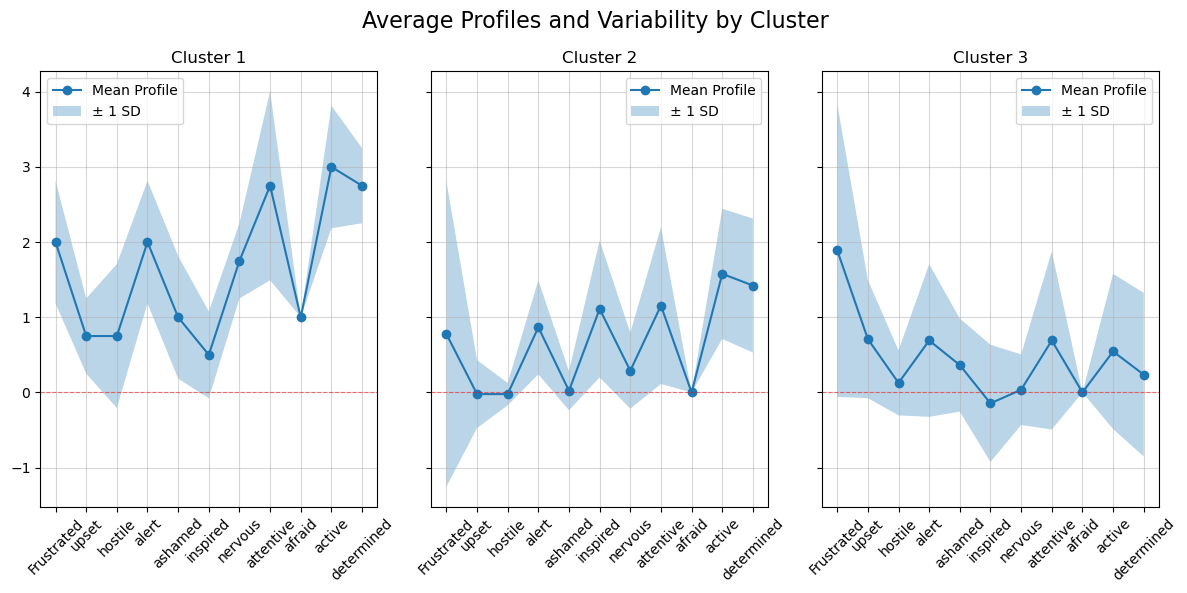

In [369]:
emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

# 3. Create a DataFrame to hold the cluster assignments
df_emotions_clustered = df_diff_emotions.copy()
df_emotions_clustered['Cluster'] = cluster_labels

# Check what cluster labels actually exist
unique_clusters = sorted(df_emotions_clustered['Cluster'].unique())
print(f"Unique cluster labels: {unique_clusters}")

# 4. Prepare for plotting
n_clusters = len(unique_clusters)
fig, axs = plt.subplots(1, n_clusters, figsize=(12, 6), sharey=True)

for i, cluster_id in enumerate(unique_clusters):
    cluster_data = df_emotions_clustered[df_emotions_clustered['Cluster'] == cluster_id]
    
    # Print the size of each cluster
    print(f"Cluster {cluster_id}: {len(cluster_data)} samples")
    
    # Compute mean and standard deviation for this cluster
    mean_profile = cluster_data.iloc[:, :-1].mean()  # exclude 'Cluster' column
    std_profile = cluster_data.iloc[:, :-1].std()
    
    x = np.arange(len(emotions_columns))
    
    # Plot
    axs[i].plot(x, mean_profile, marker='o', label='Mean Profile')
    axs[i].fill_between(x, mean_profile - std_profile, mean_profile + std_profile, alpha=0.3, label='± 1 SD')
    
    # Add horizontal line at y=0
    axs[i].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    
    axs[i].set_title(f'Cluster {cluster_id}')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(emotions_columns, rotation=45)
    axs[i].grid(True, alpha=.5)
    axs[i].legend()

fig.suptitle('Average Profiles and Variability by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

In [371]:
# First, create a new dataframe with individual and cluster information
individual_clusters = pd.DataFrame({
    'Individual': df['Individual'],
    'Cluster': cluster_labels
})

# Create a cross-tabulation (contingency table)
cluster_distribution = pd.crosstab(
    individual_clusters['Individual'], 
    individual_clusters['Cluster'],
    rownames=['Individual'],
    colnames=['Cluster']
)

# Fill any missing values with 0 (in case some individuals don't appear in some clusters)
cluster_distribution = cluster_distribution.fillna(0).astype(int)

# Add a total column
cluster_distribution['Total'] = cluster_distribution.sum(axis=1)

# Determine the dominant cluster for each individual
dominant_cluster = cluster_distribution.iloc[:, :-1].idxmax(axis=1)
cluster_distribution['Dominant_Cluster'] = dominant_cluster

# Get the list of individuals in each dominant cluster
cluster_groups = {}
for cluster in sorted(dominant_cluster.unique()):
    individuals = dominant_cluster[dominant_cluster == cluster].index.tolist()
    cluster_groups[cluster] = individuals

# Print the individuals in each cluster
for cluster, individuals in cluster_groups.items():
    print(f"Individuals in Cluster {cluster}: {', '.join(map(str, individuals))}")

Individuals in Cluster 1: 17
Individuals in Cluster 2: 2, 3, 4, 6, 8, 9, 10, 15, 19, 21, 22, 23, 24, 25
Individuals in Cluster 3: 1, 5, 7, 11, 12, 13, 14, 16, 18, 20, 26
